# Peptide Retention Time Prediction using Encoder-Only Transformer – Training Notebook

This notebook trains a Encoder-Only Transformer model to predict peptide retention times from sequence.

---

## 1. Setup & Imports

In [9]:
import sys
sys.path.append('./src')  # so we can import rt_transformer.py

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTEncoderModel, split_dataset, collate, run_epoch, compute_metrics

import torch
from torch import nn
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

## 2. Configuration
Set data path, model hyperparameters, and training settings.

In [21]:
DATA_PATH = "data/misc_dia.txt"
MODEL_PATH = "models/rt_encoder_model_misc_dia_64_4_5.pt"

# Model config
BATCH_SIZE = 64
EPOCHS = 600
LEARNING_RATE = 3e-4
D_MODEL = 64
N_HEADS = 4
N_LAYERS = 5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Using device: cuda


## 3. Data Preparation
Load the dataset, split into train/validation, and create DataLoaders.

In [22]:
# Initialize tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Split into train/val
train_ds, val_ds = split_dataset(dataset, val_ratio=0.05, seed=SEED)

# DataLoaders
coll = lambda b: collate(b, tokenizer.pad_id)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=coll)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=coll)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

Train samples: 139258, Val samples: 7329


## 4. Model Initialization
Create the Transformer model and optimizer.

In [23]:
model = PeptideRTEncoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.SmoothL1Loss()

print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model size: 255938 parameters


## 5. Training Loop
Train the model and monitor loss.

In [ ]:
train_losses, val_losses = [], []

#model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
for epoch in range(0, EPOCHS):
    train_loss = run_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss   = run_epoch(model, val_loader,   loss_fn, None, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.6f} | val loss {val_loss:.6f}")
    torch.save(model.state_dict(), MODEL_PATH)

Epoch 500 | train loss 230.692542 | val loss 182.061528
Epoch 501 | train loss 229.961001 | val loss 167.163895
Epoch 502 | train loss 230.339582 | val loss 160.709685
Epoch 503 | train loss 230.630690 | val loss 154.411406
Epoch 504 | train loss 230.213602 | val loss 169.791331
Epoch 505 | train loss 230.029392 | val loss 174.010818
Epoch 506 | train loss 230.925747 | val loss 156.222811
Epoch 507 | train loss 230.360642 | val loss 166.067663
Epoch 508 | train loss 230.788324 | val loss 188.375597
Epoch 509 | train loss 230.530945 | val loss 163.304451
Epoch 510 | train loss 231.003127 | val loss 169.914494
Epoch 511 | train loss 230.237441 | val loss 167.705730
Epoch 512 | train loss 230.611270 | val loss 162.765260
Epoch 513 | train loss 230.928723 | val loss 154.383127
Epoch 514 | train loss 229.428284 | val loss 175.403997
Epoch 515 | train loss 230.434982 | val loss 160.755615
Epoch 516 | train loss 229.239707 | val loss 166.016869
Epoch 517 | train loss 231.335755 | val loss 171

KeyboardInterrupt: 

## 6. Plot Training Curve

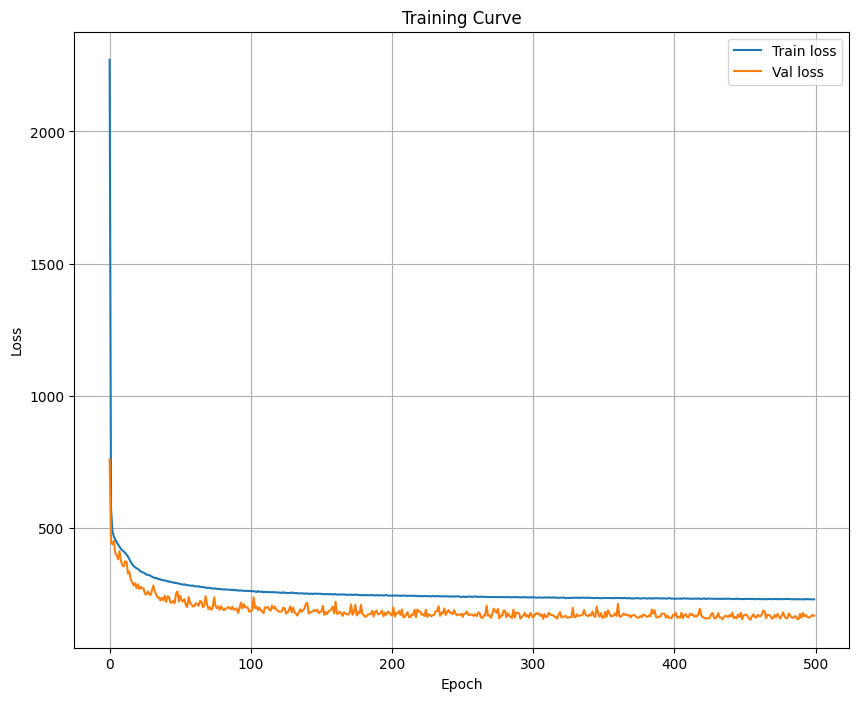

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.grid(True)
plt.show()

## 7. Compute Main Metrics for Trained Model

In [24]:
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for seqs, mask, rts in val_loader:
        seqs, mask, rts = seqs.to(DEVICE), mask.to(DEVICE), rts.to(DEVICE)
        preds = model(seqs, mask)
        all_preds.append(preds.cpu())
        all_trues.append(rts.cpu())
all_preds = torch.cat(all_preds)
all_trues = torch.cat(all_trues)

metrics = compute_metrics(all_preds, all_trues)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.5f}")



Validation metrics for model:
MAE       : 124.70908
MSE       : 30580.97461
RMSE      : 174.87416
Max_Abs_Error: 1438.52344
Median_Abs_Error: 92.15338
Mean_Abs_Percentage_Error: inf
Std_Error : 174.85783
Std_True  : 2751.13403
Std_Pred  : 2766.68701
R2        : 0.99596
Explained_Variance: 0.99596
Pearson   : 0.99801
Spearman  : 0.99837
